### Imports

In [1]:
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from itertools import product
from sklearn.metrics import mean_squared_error, confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVR
import statsmodels.api as sm

### Table of Contents
1) Introduction

2) Data Citation

3) Load and transform dataset

4) Exploratory Data Analysis

5) Split the data

6) RandomForestRegressor()

7) LinearRegression()

8) Support Vector Regression

9) GradientBoostingRegressor()

10) Evaluate the best model on the testing set

11) Conclusion

### 1) Introduction
We will be predicting the average rating for San Francisco Airbnb listings. The dataset we will be using is updated as of December 2023 and has 6175 observations with over 50 columns. The listings are from a variety of neighborhoods, price ranges, and room types. The rating is a continuous value from 1 to 5 stars, so this is a regression problem. We are given various features about the listing such as the price, amenities, host response rate, room type, number of beds, and where the host lives. The goals of this project are to create sufficient models to predict the rating and determine which features of the living space have significant impacts on the rating.

One factor that I think will contribute significantly to the rating is the price. It may be the case that fancier, more expensive listings are located in nicer areas that contribute positively to a guest's experience. Second, I think another significant factor to the rating will be the host response rate. If the host does not respond often, maybe the guests are more likely to get frustrated and leave a lower rating. Third, another contributing factor could be the room type. Room types that offer more solitude could be more favorable. Lastly, another contributing factor could be the number of amenities. I believe that a higher amount of amenities will improve the experience, resulting in a higher rating.

### 2) Data Citation

The data was found from an Airbnb website showcasing listing data in different cities.

Formal citation: 
**Airbnb. (2023). San Francisco. Airbnb. http://insideairbnb.com/get-the-data/**

### 3) Load and transform dataset

Read in the data and drop unneeded columns. We will be dropping all the review scores that are not the overall rating because we want to predict the overall rating using unrelated features.

In [2]:
df = pd.read_csv('sf1.csv')
df.drop(columns=['id','scrape_id', 'listing_url', 'source', 'description', 'calendar_updated',
                 'bedrooms', 'bathrooms', 'neighbourhood_group_cleansed', 'picture_url',
                 'host_id', 'host_url', 'host_thumbnail_url', 'host_picture_url', 'host_name',
                 'neighbourhood', 'last_scraped', 'property_type', 'calendar_last_scraped', 'review_scores_accuracy',
                 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location',
                 'review_scores_value', 'latitude', 'name', 'longitude', 'minimum_nights', 'maximum_nights', 
                 'minimum_minimum_nights','maximum_minimum_nights', 'minimum_maximum_nights',
                 'maximum_maximum_nights', 'minimum_nights_avg_ntm',
                 'maximum_nights_avg_ntm', 'number_of_reviews_ltm', 'number_of_reviews_l30d'], inplace=True)

Drop all observations that have missing values for `review_scores_rating`. This column is the overall rating (the response variable). For the purpose of training our models, we cannot have missing values for this column.

In [3]:
df.dropna(subset=['review_scores_rating'], inplace=True)

Transform the dataset by changing datatypes and adding new columns. We will be adding columns that specify whether there is a neighborhood overview, whether the host lives in San Francisco, how long the host has been a host, whether the host is a superhost, days since first and last review, the number of amenities, if there is a "host about" (about the host), and the host response rate and acceptance rate.

In [4]:
df['has_neighborhood_overview'] = [True if pd.isna(overview) == False else False for overview in df['neighborhood_overview']]
df['host_in_SF'] = [True if (pd.isna(location) == False) and ('San Francisco' in location) else False for location in df['host_location']]
for idx in df.index:
    loc = df.loc[idx, 'host_location']
    if pd.isna(loc):
        df.loc[idx, 'host_in_SF'] = 'Unknown'

df['days_as_host'] = [(pd.Timestamp.now() - pd.to_datetime(host_since)).days if pd.isna(host_since) == False else
                      None for host_since in df['host_since']]
df['host_is_superhost'] = [True if status == 't' else False for status in df['host_is_superhost']]
df['host_verifications'] = [ast.literal_eval(ver) if pd.isna(ver) == False else ver for ver in df['host_verifications']]

for idx in df.index:
    if idx == 540:
        df.loc[idx, 'num_host_verifications'] = None
        continue
    host_verifications = df.loc[idx, 'host_verifications']
    df.loc[idx, 'num_host_verifications'] = len(host_verifications)

df['days_since_first_review'] = [(pd.Timestamp.now() - pd.to_datetime(date)).days if pd.isna(date) == False else None for date in df['first_review']]
df['days_since_last_review'] = [(pd.Timestamp.now() - pd.to_datetime(date)).days if pd.isna(date) == False else None for date in df['last_review']]
df['instant_bookable'] = [True if status == 't' else False for status in df['instant_bookable']]
df['amenities'] = [ast.literal_eval(amenities) for amenities in df['amenities']]
df['num_amenities'] = [len(amenities) for amenities in df['amenities']]
df['has_host_about'] = [True if pd.isna(about) == False else False for about in df['host_about']]

for idx in df.index:
    rate1  = df.loc[idx, 'host_response_rate']
    if pd.isna(rate1):
        int_rate1 = rate1
        continue
    if (pd.isna(rate1) == False) and (len(rate1) == 4):
        int_rate1 = int(rate1[:3])
    if len(rate1) == 3:
        int_rate1 = int(rate1[:2])
    df.loc[idx, 'host_response_rate'] = int_rate1
for idx in df.index:
    rate2 = df.loc[idx, 'host_acceptance_rate']
    if pd.isna(rate2):
        int_rate2 = rate2
        continue
    if (len(rate2) == 4) and (pd.isna(rate2) == False):
        int_rate2 = int(rate2[:3])
    if len(rate2) == 3:
        int_rate2 = int(rate2[:2])
    df.loc[idx, 'host_acceptance_rate'] = int_rate2

df['price'] = [price.replace(',', '') for price in df['price']]
df['price'] = [float(price[1:]) for price in df['price']]

df['host_response_rate'] = df['host_response_rate'].astype(float)
df['host_acceptance_rate'] = df['host_acceptance_rate'].astype(float)

We will deal with relevant missing values by imputing them using using KNNImputer().

In [5]:
knn_imputer1 = KNNImputer(n_neighbors=3)
df['beds'] = knn_imputer1.fit_transform(df['beds'].to_numpy().reshape(-1,1))

df['host_response_time'].fillna('Unknown', inplace=True)

knn_imputer2 = KNNImputer(n_neighbors=3)
df['host_response_rate'] = knn_imputer2.fit_transform(df['host_response_rate'].to_numpy().reshape(-1,1))

knn_imputer3 = KNNImputer(n_neighbors=3)
df['host_acceptance_rate'] = knn_imputer3.fit_transform(df['host_acceptance_rate'].to_numpy().reshape(-1,1))

knn_imputer4 = KNNImputer(n_neighbors=3)
df['num_host_verifications'] = knn_imputer4.fit_transform(df['num_host_verifications'].to_numpy().reshape(-1,1))

knn_imputer5 = KNNImputer(n_neighbors=3)
df['days_since_first_review'] = knn_imputer5.fit_transform(df['days_since_first_review'].to_numpy().reshape(-1,1))

knn_imputer6 = KNNImputer(n_neighbors=3)
df['days_since_last_review'] = knn_imputer6.fit_transform(df['days_since_last_review'].to_numpy().reshape(-1,1))

knn_imputer7 = KNNImputer(n_neighbors=3)
df['reviews_per_month'] = knn_imputer7.fit_transform(df['reviews_per_month'].to_numpy().reshape(-1,1))

knn_imputer8 = KNNImputer(n_neighbors=3)
df['days_as_host'] = knn_imputer8.fit_transform(df['days_as_host'].to_numpy().reshape(-1,1))

### 4) Exploratary Data Analysis

What is the distribution of reviews across the whole dataset?

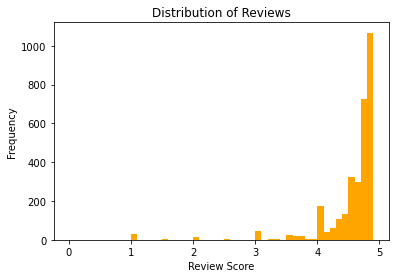

In [6]:
import seaborn as sns
from scipy.stats import gaussian_kde
plt.hist(df['review_scores_rating'], bins=np.arange(0, 5, 0.1), color='orange')
plt.xlabel('Review Score')
plt.ylabel('Frequency')
plt.title('Distribution of Reviews')
plt.show()

The distribution is skewed. Most observations have a review close to 5 stars. There are a few outliers with ratings under 4 stars.

Does price impact the rating? We will be binning the prices into groups and looking at the median rating per group. We are using medians instead of means because the data has a skewed distribution.

In [7]:
 # 0.2, 0.4, 0.6, 0.8, 1 quantiles
bins = [0, 86, 123, 174, 275, 50000 ]
df['price group'] = pd.cut(df['price'], bins=bins)

 # median review per status
df.groupby('price group')[['review_scores_rating']].median() 

,review_scores_rating
price group,
"(0, 86]",4.80
"(86, 123]",4.87
"(123, 174]",4.90
"(174, 275]",4.94
"(275, 50000]",4.96


Kernel Density Estimation plot with a Gaussian kernel for each price group

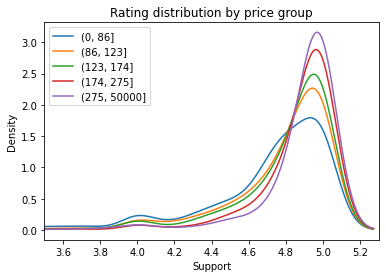

In [8]:
for status in np.sort(df['price group'].unique()):
    vals = df.loc[df['price group'] == status, 'review_scores_rating']
    kde = sm.nonparametric.KDEUnivariate(vals)
    kde.fit(kernel='gau', fft=False, bw=0.09)
    plt.plot(kde.support, kde.density)
plt.legend(['(0, 86]','(86, 123]', '(123, 174]', '(174, 275]', '(275, 50000]'])
plt.title('Rating distribution by price group')
plt.xlabel('Support')
plt.ylabel('Density')
plt.xlim(3.5, 5.3)
plt.show()

The curves shift to the right as the price group increases. We also see that the larger price groups have higher densities for larger values of the support. This means that higher price of the listing means higher rating. The curves get narrower as the price group increases. This indicates that higher price groups have lower variance in their reviews. This is evidence supporting the claim that higher price means more stable reviews.

Do super hosts have higher median ratings?

In [9]:
 # median review per status
df.groupby('host_is_superhost')[['review_scores_rating']].median()

,review_scores_rating
host_is_superhost,
False,4.83
True,4.93


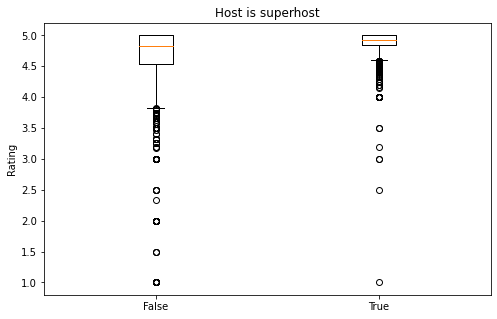

In [10]:
data = []
labs = []
for status in df['host_is_superhost'].unique():
    vals = df.loc[df['host_is_superhost'] == status, 'review_scores_rating']
    data.append(vals)
    labs.append(status)

plt.figure(figsize=(8, 5))
plt.boxplot(data)
plt.xticks([1,2], labs)
plt.ylabel('Rating')
plt.title('Host is superhost')
plt.show()

We see that superhosts have higher median reviews and a lower spread of ratings than non-superhosts. Perhaps superhosts are more experienced at managing their listing(s)?

Does the host being in San Francisco impact the reviews?

In [11]:
 # median review per status
df.groupby('host_in_SF')[['review_scores_rating']].median()

,review_scores_rating
host_in_SF,
False,4.94
True,4.91
Unknown,4.81


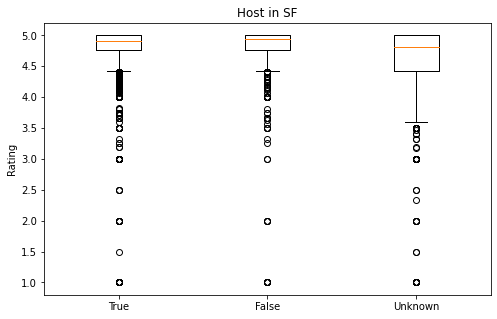

In [12]:
data = []
labs = []
for status in df['host_in_SF'].unique():
    vals = df.loc[df['host_in_SF'] == status, 'review_scores_rating']
    data.append(vals)
    labs.append(status)

plt.figure(figsize=(8, 5))
plt.boxplot(data)
plt.xticks([1,2, 3], labs)
plt.ylabel('Rating')
plt.title('Host in SF')
plt.show()

We see that hosts that do not live in San Francisco have slightly higher median reviews. However, the boxplots are fairly similar. We can conclude that the host location does not impact the rating.

Does the room type impact the rating?

In [13]:
 # median review per status
df.groupby('room_type')[['review_scores_rating']].median() 

,review_scores_rating
room_type,
Entire home/apt,4.93
Hotel room,4.46
Private room,4.86
Shared room,4.73


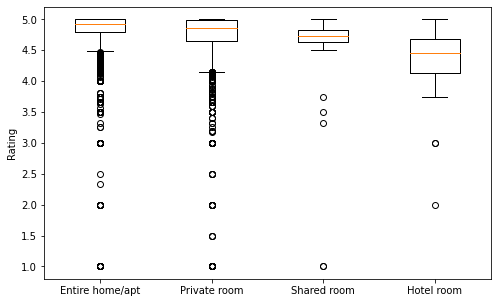

In [15]:
data = []
labels = []
for room_type in df['room_type'].unique():
    room_type_df = df.loc[df['room_type'] == room_type, 'review_scores_rating']
    data.append(room_type_df)
    labels.append(room_type)

plt.figure(figsize=(8, 5))
plt.boxplot(data)
plt.ylabel('Rating')
plt.xticks([1,2,3,4], labels)
plt.show()

Entire homes/apts have the highest median reviews while hotel rooms have the lowest median reviews. This is to be expected because having an entire house/apartment is more favorable than living in a hotel or shared room.

Does 100% response rate impact the reviews?

In [16]:
hundred = df.loc[df['host_response_rate'] == 100, :]
print(f' Median review for 100% response rate: {hundred["review_scores_rating"].median()}')
not_hundred = df.loc[df['host_response_rate'] != 100, :]
print(f' Median review for <100% response rate: {not_hundred["review_scores_rating"].median()}')

 Median review for 100% response rate: 4.91
 Median review for <100% response rate: 4.88


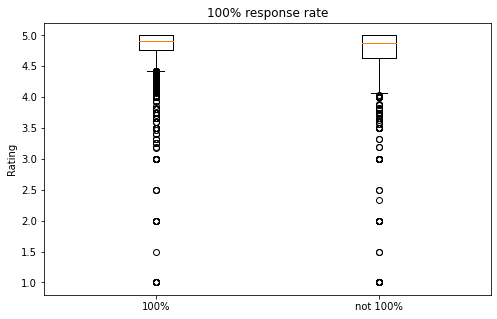

In [17]:
data = []
labels = ['100%', 'not 100%']
data.append(df.loc[df['host_response_rate'] == 100, 'review_scores_rating'])
data.append(df.loc[df['host_response_rate'] != 100, 'review_scores_rating'])

plt.figure(figsize=(8, 5))
plt.boxplot(data)
plt.title('100% response rate')
plt.ylabel('Rating')
plt.xticks([1,2], labels)
plt.show()

100% response rates have slightly higher median reviews. However, this is not much different than the distribution for <100% response rate.

Does more amenities mean higher mean rating?

In [18]:
# bin the number of amenities into groups
bins = [0, 21, 30, 39, 49, 166]
df['amenities_group'] = pd.cut(df['num_amenities'], bins=bins)
df.groupby('amenities_group')[['review_scores_rating']].median()

,review_scores_rating
amenities_group,
"(0, 21]",4.82
"(21, 30]",4.83
"(30, 39]",4.90
"(39, 49]",4.93
"(49, 166]",4.96


Kernel Density plot with Gaussian kernel for each amenities group

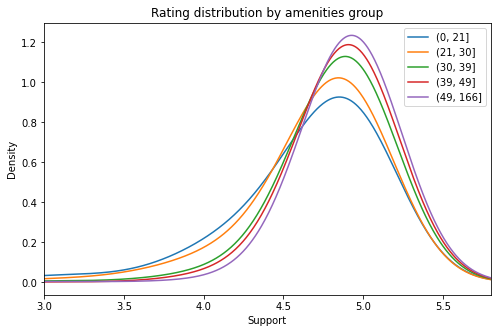

In [19]:
plt.figure(figsize=(8, 5))
for group in np.sort(df['amenities_group'].unique()):
    vals = df.loc[df['amenities_group'] == group, 'review_scores_rating']
    kde = sm.nonparametric.KDEUnivariate(vals)
    kde.fit(kernel='gau', fft=False, bw=0.3)
    plt.plot(kde.support, kde.density)

plt.legend(['(0, 21]', '(21, 30]', '(30, 39]', '(39, 49]', '(49, 166]'])
plt.title('Rating distribution by amenities group')
plt.xlabel('Support')
plt.ylabel('Density')
plt.xlim(3, 5.8)
plt.show()

There is a positive relationship between number of amenities and median ratings. This is indicated by how the curves shift to the right and have higher peaks around 5.0 as the rating group increases. Listings with nore amenities also have a lower variance for ratings. This implies that listings with many amenities are more consistent in creating positive guest experiences.

How does `review_scores_rating` correlate with other variables? We will look at the correlation matrix of this dataset, but only the column with `review_scores_rating`.

In [20]:
pd.Series(abs(df.corr()['review_scores_rating']).sort_values(ascending=False)).head(10)

review_scores_rating                            1.000000
calculated_host_listings_count_private_rooms    0.353459
calculated_host_listings_count                  0.339906
host_is_superhost                               0.269119
num_amenities                                   0.236769
availability_30                                 0.163229
availability_60                                 0.154489
calculated_host_listings_count_entire_homes     0.146990
availability_90                                 0.143487
days_since_last_review                          0.143119
Name: review_scores_rating, dtype: float64

In addition to the variables we explored and created earlier, `calculated_host_listings_count_private_rooms`, `calculated_host_listings_count`, and `calculated_host_listings_count_entire_homes` have some correlation with the review score. These represent the number of private rooms, total listings, and entire homes the host has in the region. `availability_30`, `availability_60`, and `availability_90` also have some correlation with the rating. Thus, we will also be using these variables to predict the rating.

### 5) Split the data 

First, add a categorical variable for the rating so we can do stratified sampling.

In [21]:
bins_list = [0, 3, 4, 4.2, 4.4, 4.6, 4.8, 5]
bins = pd.cut(df['review_scores_rating'], bins=bins_list, labels=[1, 2, 3, 4, 5, 6, 7])
df['binned_rating'] = bins

bins_interval = pd.cut(df['review_scores_rating'], bins=bins_list)

Create dummy variables, split data into 80% training and 20% testing stratifying on the rating, and define predictors and response. We need to split the data into two sets so we can use one to train the models and one to test the models. We need to stratify the data so that there is equal representation in both sets. This will make our predictions more generalizable to the entire population of all Airbnb listings in San Francisco.

In [22]:
X = pd.get_dummies(data=df, columns=['host_response_time', 'room_type', 'host_in_SF'], drop_first=True)

training, testing = train_test_split(X, test_size=0.2, stratify=df['binned_rating'], random_state=35)

predictors_training = training[['host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'accommodates', 'beds', 'price',
                                'number_of_reviews', 'reviews_per_month', 'has_neighborhood_overview', 'days_as_host',
                                'num_host_verifications', 'days_since_first_review', 'days_since_last_review',
                                'num_amenities', 'host_response_time_a few days or more', 'host_response_time_within a day',
                                'host_response_time_within a few hours', 'host_response_time_within an hour',
                                'room_type_Hotel room', 'room_type_Private room', 'room_type_Shared room',
                                'host_in_SF_True', 'host_in_SF_Unknown', 'calculated_host_listings_count_private_rooms',
                                'calculated_host_listings_count', 'availability_30', 'availability_60',
                                'calculated_host_listings_count_entire_homes', 'availability_90', 'instant_bookable',
                                'availability_365']]

predictors_training = (predictors_training - predictors_training.mean()) / predictors_training.std()
response_training = training['review_scores_rating'].to_numpy()
response_training_binned = training['binned_rating'].to_numpy()

predictors_testing = testing[['host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'accommodates', 'beds', 'price',
                                'number_of_reviews', 'reviews_per_month', 'has_neighborhood_overview', 'days_as_host',
                                'num_host_verifications', 'days_since_first_review', 'days_since_last_review',
                                'num_amenities', 'host_response_time_a few days or more', 'host_response_time_within a day',
                                'host_response_time_within a few hours', 'host_response_time_within an hour',
                                'room_type_Hotel room', 'room_type_Private room', 'room_type_Shared room',
                                'host_in_SF_True', 'host_in_SF_Unknown', 'calculated_host_listings_count_private_rooms',
                                'calculated_host_listings_count', 'availability_30', 'availability_60',
                                'calculated_host_listings_count_entire_homes', 'availability_90', 'instant_bookable',
                                'availability_365']]
predictors_testing = (predictors_testing - predictors_testing.mean()) / predictors_testing.std()
response_testing = testing['review_scores_rating'].to_numpy()
response_testing_binned = testing['binned_rating'].to_numpy()


In [23]:
predictors_vals_training = predictors_training.to_numpy()

### 6) RandomForestRegressor()

Use 10-fold cross validation and RandomForestRegressor() to predict the rating. This model uses multiple decision trees and averages the results to make predictions. Cross-validation is when we split the data into 10 groups and rotate the training and testing sets. Cross validation makes it so that we have new training and testing data everytime; this provides a less biased MSE estimate. For this model and future models, we will be using the metric mean squared error (MSE) to evaluate model performance. We will also extract the feature importances to determine which variables are useful in determining the rating.

In [24]:
# predictor grid
num_estimators = [50, 150, 250]
min_samples_split = [1.0, 6, 15]
min_samples_leaf = [1, 6, 15]
max_features = [1, 'sqrt', 10]

rf_parameters = list(product(num_estimators, min_samples_split, min_samples_leaf, max_features))
rf_results = {}

feature_imps_rfr = []

# train the model
for combination in rf_parameters:
    n_estimators, m_samples_split, m_samples_leaf, max_f = combination[0], combination[1], combination[2], combination[3]
    model = RandomForestRegressor(n_estimators=n_estimators, min_samples_split=m_samples_split, min_samples_leaf=m_samples_leaf,
                                  max_features=max_f)
    mse_values = []
    kfold = StratifiedKFold(n_splits=10)
    for train_idx, test_idx in kfold.split(predictors_vals_training, response_training_binned):
        x_train, x_test = predictors_vals_training[train_idx], predictors_vals_training[test_idx]
        y_train, y_test = response_training[train_idx], response_training[test_idx]
        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)
        mse = mean_squared_error(y_true=y_test, y_pred=y_pred)
        mse_values.append(mse)
        fi = list(model.feature_importances_)
        feature_imps_rfr.append(fi)
    rf_results[str(combination)] = np.mean(mse_values)


The 10 best models

In [25]:
results = pd.Series(rf_results, name='MSE').sort_values() 
results.head(10).sort_values()

(250, 6, 6, 'sqrt')     0.142535
(250, 6, 15, 10)        0.142955
(250, 15, 15, 10)       0.142993
(50, 6, 15, 10)         0.143241
(250, 15, 6, 'sqrt')    0.143335
(150, 15, 6, 'sqrt')    0.143371
(50, 6, 6, 'sqrt')      0.143550
(150, 15, 6, 10)        0.143629
(150, 15, 15, 10)       0.143652
(150, 6, 15, 10)        0.143780
Name: MSE, dtype: float64

The best RandomForestRegressor() model was for n_estimators=250, min_samples_split=6, min_samples_leaf=6, and max_features='sqrt' with a MSE of 0.143.

In [26]:
print(f'Standard deviation in MSE across models {results.std()}')

Standard deviation in MSE across models 0.024896391457763015


The models had some variance.

Feature importance plot

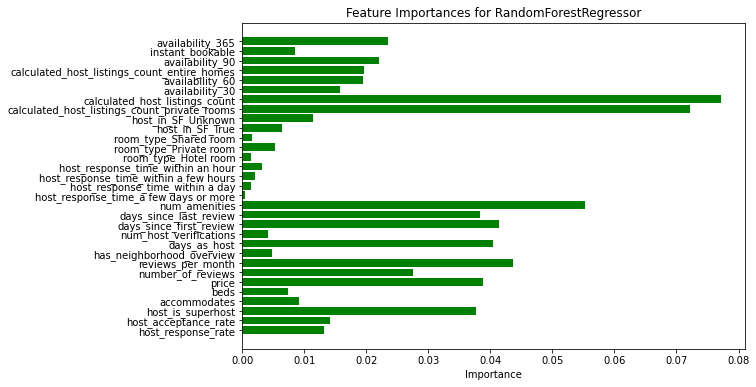

In [52]:
mean_imps = np.array(feature_imps_rfr).mean(axis=0)
imp_dict = {}
for idx, col in enumerate(predictors_training.columns):
    imp_dict[col] = mean_imps[idx]
plt.figure(figsize=(9, 6))
plt.barh(y=list(imp_dict.keys()), width=list(imp_dict.values()), color='green')
plt.xlabel('Importance')
plt.title('Feature Importances for RandomForestRegressor')
plt.show()

The most important variables for predicting rating are by far `calculated_host_listings_count_private_rooms` and `calculated_host_listings_count`. Just like what was seen during the exploratory data analysis, `num_amenities` (the number of amenities) also had some impact on the rating.

Next, we will plot the average MSE for each hyperparameter value.

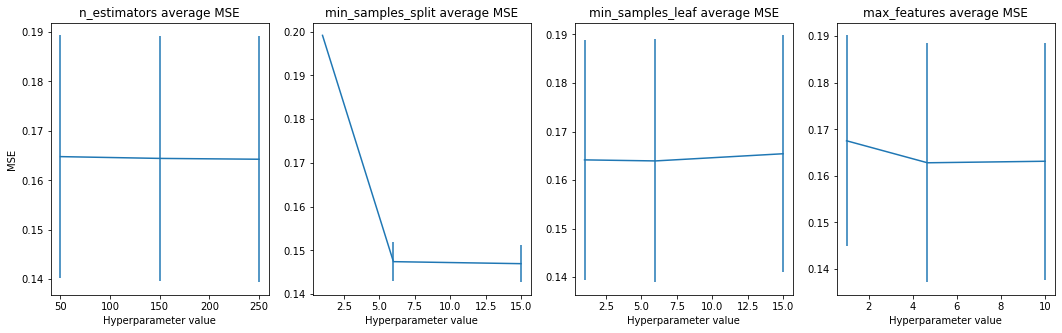

In [40]:
fig, axes =plt.subplots(1, 4, figsize=(18, 5))
count = 0
for param_num in range(1, 5):
    one = []
    two = []
    three = []
    for key in rf_results.keys(): # n_estimators
        if param_num == 2:
            params = min_samples_split
            param_name = 'min_samples_split'
            if 1.0 == ast.literal_eval(key)[1]:
                mse = rf_results[key]
                one.append(mse)
            if 6 == ast.literal_eval(key)[1]:
                mse = rf_results[key]
                two.append(mse)
            if 15 == ast.literal_eval(key)[1]:
                mse = rf_results[key]
                three.append(mse)
        if param_num == 1:
            params = num_estimators
            param_name = 'n_estimators'
            if 50 == ast.literal_eval(key)[0]:
                mse = rf_results[key]
                one.append(mse)
            if 150 == ast.literal_eval(key)[0]:
                mse = rf_results[key]
                two.append(mse)
            if 250 == ast.literal_eval(key)[0]:
                mse = rf_results[key]
                three.append(mse)
        if param_num == 3:
            params = min_samples_leaf
            param_name = 'min_samples_leaf'
            if 1 == ast.literal_eval(key)[2]:
                mse = rf_results[key]
                one.append(mse)
            if 6 == ast.literal_eval(key)[2]:
                mse = rf_results[key]
                two.append(mse)
            if 15 == ast.literal_eval(key)[2]:
                mse = rf_results[key]
                three.append(mse)
        if param_num == 4:
            params = [1, 4.67, 10]
            param_name = 'max_features'
            if 1 == ast.literal_eval(key)[3]:
                mse = rf_results[key]
                one.append(mse)
            if 'sqrt' == ast.literal_eval(key)[3]:
                mse = rf_results[key]
                two.append(mse)
            if 10 == ast.literal_eval(key)[3]:
                mse = rf_results[key]
                three.append(mse)
    axes[count].set_title(f'{param_name} average MSE')
    axes[count].set_xlabel('Hyperparameter value')
    axes[0].set_ylabel('MSE')
    axes[count].errorbar(x=params, y=[np.mean(one), np.mean(two), np.mean(three)], yerr=[np.std(one), np.std(two), np.std(three)])
    count += 1



For each value of the hyperparameter for n_estimators, min_samples_leaf, and max_features, the MSE did not change significantly. For min_samples_split, the MSE was much higher for the hyperparameter value of 1. This suggests that setting min_samples_split = 1 is not favorable for RandomForestRegressor().

### 7) LinearRegression()

We will do 20 iterations of LinearRegression() with 10-fold cross validation to predict rating. This model uses simple linear regression (y= a + bx1 + bx2 + ... ). 
The estimated coefficients will tell us which variables were the most useful.

In [42]:
# no parameters to tune

model = LinearRegression()
lr_results = {}
coef_list = []
for iteration in range(0, 20):
    mse_values = []
    kfold = StratifiedKFold(n_splits=10, shuffle=True) # shuffle before splitting into batches to get different results
    for train_idx, test_idx in kfold.split(predictors_vals_training, response_training_binned):
        x_train, x_test = predictors_vals_training[train_idx], predictors_vals_training[test_idx]
        y_train, y_test = response_training[train_idx], response_training[test_idx]
        model.fit(x_train, y_train)
        coefs = model.coef_
        coef_list.append(coefs)
        y_pred = model.predict(x_test)
        mse = mean_squared_error(y_true=y_test, y_pred=y_pred)
        mse_values.append(mse)
    lr_results[iteration] = mse_values

Average MSE across all folds for each iteration

In [43]:
pd.DataFrame(lr_results).T.mean(axis=1) 

0     0.155752
1     0.155967
2     0.155152
3     0.155150
4     0.155139
5     0.155316
6     0.156047
7     0.155511
8     0.155478
9     0.155339
10    0.156475
11    0.155150
12    0.155539
13    0.155636
14    0.155293
15    0.155329
16    0.155035
17    0.155560
18    0.155007
19    0.155434
dtype: float64

The MSE did not vary by much across each iteration.

Plot the LinearRegression() coefficients

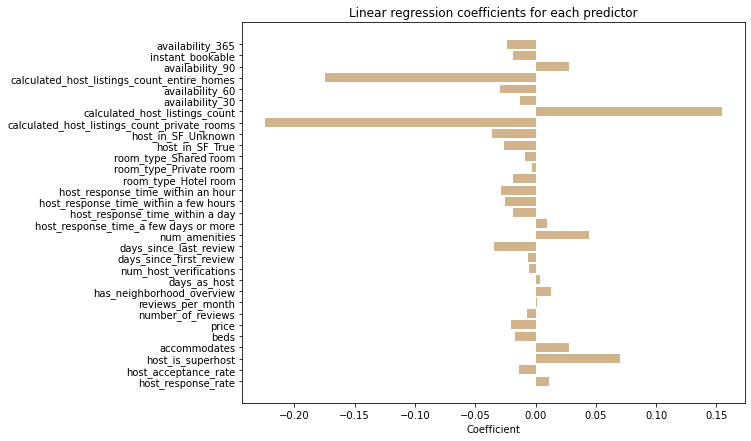

In [54]:
coef_arr = np.array(coef_list)
mean_coefs = np.mean(coef_arr, axis=0)
plt.figure(figsize=(9, 7))
plt.barh(predictors_training.columns, mean_coefs, color='tan')
plt.title('Linear regression coefficients for each predictor')
plt.xlabel('Coefficient')
plt.show()

Just like for RandomForestRegressor(), `calculated_host_listing_count_private_rooms` and `calculated_host_listing_count` were important in predicting the rating. This is indicated by how the estimated coefficients are far from 0. For example, when keeping all other variables constant, increasing `calculated_host_listing_count` by 1 scaled unit increases the rating by almost 0.2. Unlike for RandomForestRegressor(), 
`calculated_host_listing_count_entire_homes` was significantly useful in predicting the rating.

### 8) Support Vector Regression

Use 10-fold cross validation to train SVR() models. This model uses support vectors (data points that seperate data into different groups) to decide the regression function.

In [55]:
kernel = ['rbf', 'poly']
degree = [3, 4]
gamma = ['scale', 'auto']
C = [0.5, 1, 2]

svr_parameters = list(product(kernel, degree, gamma, C))
svr_results = {}
for combination in svr_parameters:
    ker, deg, gam, c = combination[0], combination[1], combination[2], combination[3]
    model = SVR(kernel=ker, degree=deg, gamma=gam, C=c)
    mse_values = []
    kfold = StratifiedKFold(n_splits=10) # stratify by the response variable using StratifiedKFold()
    for train_idx, test_idx in kfold.split(predictors_vals_training, response_training_binned):
        x_train, x_test = predictors_vals_training[train_idx], predictors_vals_training[test_idx]
        y_train, y_test = response_training[train_idx], response_training[test_idx]
        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)
        mse = mean_squared_error(y_true=y_test, y_pred=y_pred)
        mse_values.append(mse)
    # get the average MSE across all folds
    svr_results[str(combination)] = np.mean(mse_values) 

In [56]:
res = pd.Series(svr_results).sort_values()
res

('rbf', 3, 'scale', 1)       0.158740
('rbf', 4, 'scale', 1)       0.158740
('rbf', 3, 'auto', 1)        0.158744
('rbf', 4, 'auto', 1)        0.158744
('rbf', 3, 'auto', 0.5)      0.160709
('rbf', 4, 'auto', 0.5)      0.160709
('rbf', 3, 'scale', 0.5)     0.160709
('rbf', 4, 'scale', 0.5)     0.160709
('rbf', 3, 'scale', 2)       0.161563
('rbf', 4, 'scale', 2)       0.161563
('rbf', 4, 'auto', 2)        0.161571
('rbf', 3, 'auto', 2)        0.161571
('poly', 3, 'scale', 0.5)    0.182465
('poly', 3, 'auto', 0.5)     0.182470
('poly', 3, 'auto', 1)       0.187378
('poly', 3, 'scale', 1)      0.187400
('poly', 3, 'auto', 2)       0.189575
('poly', 3, 'scale', 2)      0.189631
('poly', 4, 'auto', 0.5)     0.208603
('poly', 4, 'scale', 0.5)    0.208784
('poly', 4, 'auto', 1)       0.225048
('poly', 4, 'scale', 1)      0.225536
('poly', 4, 'auto', 2)       0.260549
('poly', 4, 'scale', 2)      0.260803
dtype: float64

In [57]:
np.std(res.values)

0.031092886315906166

The different SVR() models varied more significantly than the other models.

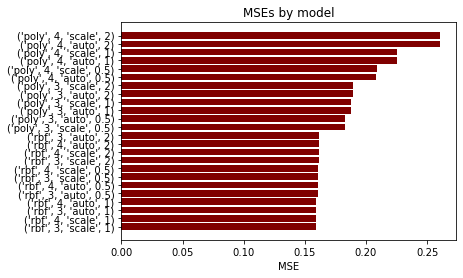

In [58]:
plt.barh(res.index, res.values, color='maroon')
plt.xlabel('MSE')
plt.title('MSEs by model')
plt.show()

The best SVR() models had an MSE of 0.15874. The parameters they had in common were kernel = 'rbf', gamma='scale', and C=1. The degree parameter unsurpisingly included both 3 and 4 since this parameter has no affect outside of kernel = 'poly'. The 'poly' kernel did not perform well on this dataset.

### 9) GradientBoostingRegressor()

Finally, we will use GradientBoostingRegressor() with 10-fold cross validation to predict the rating. This model uses sequential decision trees. We will also extract the feature importances to determine useful predictors.

In [ ]:
# parameter grid
n_estimators_list = [100, 200, 300]
learning_rate_list = [0.1, 0.3, 0.6]
min_samples_split_list = [1.0, 6, 15]
min_samples_leaf_list = [1, 6, 15]

# train the model,extract MSEs and feature importances
gbr_parameters = list(product(n_estimators_list, learning_rate_list, min_samples_split_list, min_samples_leaf_list))
gbr_results = {}
feature_imps = []
c = 0
for combination in gbr_parameters:
    n_estimators, learning, mss, msl = combination[0], combination[1], combination[2], combination[3]
    model = GradientBoostingRegressor(n_estimators=n_estimators, learning_rate=learning, min_samples_split=mss, min_samples_leaf=msl)
    mse_values = []
    kfold = StratifiedKFold(n_splits=10)
    for train_idx, test_idx in kfold.split(predictors_vals_training, response_training_binned):
        x_train, x_test = predictors_vals_training[train_idx], predictors_vals_training[test_idx]
        y_train, y_test = response_training[train_idx], response_training[test_idx]
        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)
        mse = mean_squared_error(y_true=y_test, y_pred=y_pred)
        mse_values.append(mse)
        fi = list(model.feature_importances_)
        feature_imps.append(fi)
    c = c + 1
    print(c)
    gbr_results[str(combination)] = np.mean(mse_values)
    



Top 10 GradientBoostingRegressor models

In [73]:
results = pd.Series(gbr_results, name='MSE').sort_values() 
results.head(10)

(300, 0.3, 1.0, 15)    0.147644
(200, 0.3, 1.0, 15)    0.147710
(200, 0.3, 1.0, 6)     0.147776
(300, 0.3, 1.0, 6)     0.147780
(100, 0.1, 15, 15)     0.148041
(100, 0.3, 1.0, 15)    0.148048
(300, 0.1, 1.0, 15)    0.148179
(100, 0.1, 6, 15)      0.148212
(100, 0.3, 1.0, 6)     0.148214
(300, 0.1, 1.0, 6)     0.148230
Name: MSE, dtype: float64

The best GradientBoostingRegressor() model had n_estimators=300, learning_rate=0.3, min_samples_split=1, and min_samples_leaf = 15 with a MSE of 0.148. However, the top 10 models had very similar MSEs.

In [74]:
print(f' Standard deviation of all MSEs: {results.std()}')

 Standard deviation of all MSEs: 0.018417937954542555


The MSEs did not vary by much across all models.

Plot the feature importances

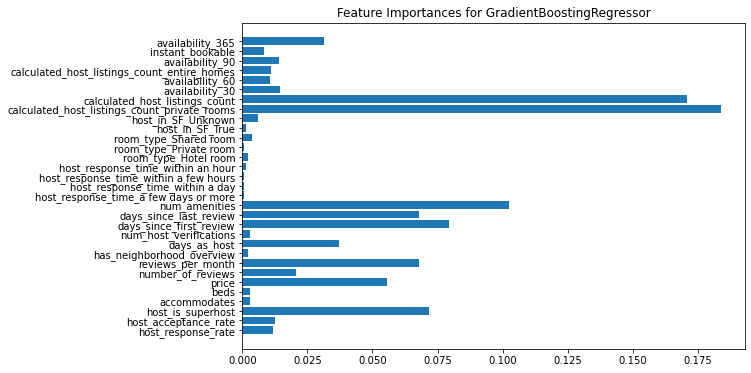

In [80]:
mean_imps = np.array(feature_imps).mean(axis=0)
imp_dict = {}
for idx, col in enumerate(predictors_training.columns):
    imp_dict[col] = mean_imps[idx]
plt.figure(figsize=(9, 6))
plt.barh(y=list(imp_dict.keys()), width=list(imp_dict.values()))
plt.title('Feature Importances for GradientBoostingRegressor')
plt.show()

Just like for the other models, `calculated_host_listings_count_private_rooms` and `calculated_host_listings_count` were the most important in predicting the rating. `num_amenities` also contributed.

Plot the average MSE for each hyperparameter value

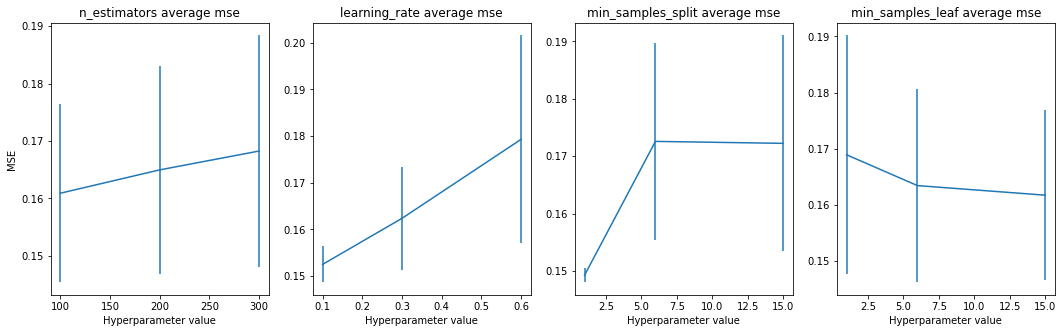

In [81]:
fig, axes = plt.subplots(1, 4, figsize=(18, 5))
param_list = [n_estimators_list, learning_rate_list, min_samples_split_list, min_samples_leaf_list]
param_name_list = ['n_estimators', 'learning_rate', 'min_samples_split', 'min_samples_leaf']
for i in range(0, 4):
    param_name = param_name_list[i]
    params = param_list[i]
    one, two, three = [], [], []
    for key in gbr_results.keys():
        key_tuple = ast.literal_eval(key)
        if key_tuple[i] == param_list[i][0]:
            mse = gbr_results[key]
            one.append(mse)
        if key_tuple[i] == param_list[i][1]:
            mse = gbr_results[key]
            two.append(mse)
        if key_tuple[i] == param_list[i][2]:
            mse = gbr_results[key]
            three.append(mse)
    axes[i].set_title(f'{param_name} average mse')
    axes[i].errorbar(x=params, y=[np.mean(one), np.mean(two), np.mean(three)], yerr=[np.std(one), np.std(two), np.std(three)])
    axes[i].set_xlabel('Hyperparameter value')
    axes[0].set_ylabel('MSE')

plt.show()

n_estimators had a slight increase in MSE as the hyperparameter value increased. learning_rate had a more significant positive relationship between hyperparameter value and MSE. min_samples_split had a large increase in MSE as the hyperparameter went from 1 to 6, but did not change significantly when it jumped from 6 to 15. min_samples_leaf had some negative association with hyperparameter value and MSE.

### 10) Evaluate the best model on the testing set

Overall, the best model was **RandomForestRegressor() with n_estimators=250, min_samples_leaf=6, min_samples_split=6, and max_features='sqrt' with an MSE of 0.143**. We will train this model on the whole training set and evaluate its performance on the testing set.

In [63]:
model = RandomForestRegressor(n_estimators=250, min_samples_leaf=6, min_samples_split=6, max_features='sqrt')
model.fit(predictors_training, response_training)
predicted_review = model.predict(predictors_testing)
test_mse = mean_squared_error(y_true=response_testing, y_pred=predicted_review)
test_mse

0.12920607199570305

The test MSE is 0.13.

Determine what bin (from 1 to 7) the predicted review is in

In [64]:
predicted_review_binned = []
for rating in predicted_review:
    if (rating > 0) and (rating <= 3):
        predicted_review_binned.append(1)
    if (rating > 3) and (rating <= 4):
        predicted_review_binned.append(2)
    if (rating > 4) and (rating <= 4.2):
        predicted_review_binned.append(3)
    if (rating > 4.2) and (rating <= 4.4):
        predicted_review_binned.append(4)
    if (rating > 4.4) and (rating <= 4.6):
        predicted_review_binned.append(5)
    if (rating > 4.6) and (rating <= 4.8):
        predicted_review_binned.append(6)
    if (rating > 4.8) and (rating <= 5):
        predicted_review_binned.append(7)
    

Plot a confusion matrix for the binned reviews

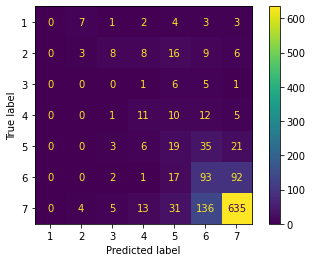

In [65]:
confusion = confusion_matrix(y_true=response_testing_binned, y_pred=predicted_review_binned)
c = ConfusionMatrixDisplay(confusion_matrix=confusion, display_labels=[1,2,3,4,5,6,7])
c.plot()

The model clearly did the best at predicting ratings near 5 because most of the rating values were near 5. For the most part, as rating value increases, the model does better at predicting the rating group accurately. None of the reviews in group 1 got predicted accurately. Thus, the model is not good at identifying very low reviews. But overall, the model did a decent job at classifying the correct groups.

Plot the actual vs. predicted values

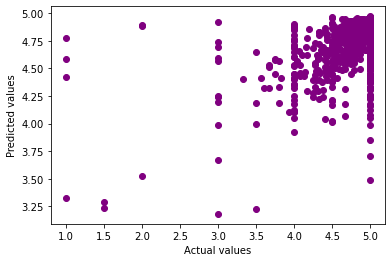

In [66]:
plt.scatter(response_testing, predicted_review, color='purple')
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.show()

If the model did well we should see a straight-line relationship between predicted vs. actual rating values. For low reviews (<3 stars), the model predicted a rating significantly higher than the acutal rating. For example, for 1-star ratings, the lowest predicted rating was about 3.25 stars. Towards the top right corner of the plot, we see a rough positive association. This indicates that the model did okay at predicting higher values.

### 11) Conclusion

The best model in predicting rating was RandomForestRegressor(n_estimators=150, min_samples_leaf=15, min_samples_split=15, max_features=10). It achieved an MSE of 0.143 during 10-fold cross validation and a test MSE of 0.17. The second best model was GradientBoostingRegressor(), then LinearRegression(), then SVR(). The tree-based models performed best in predicting the rating. If we take the square root of the test MSE to get a root MSE of 0.41, we have that the predicted ratings deviate from the actual ratings by about 0.41. This metric was most likely heightened by the presence of the few ratings below 4 stars. 

Surprisingly, the most important factors in determining the rating were  `calculated_host_listings_count_private_rooms` and `calculated_host_listings_count`. It appears that the number of listings that the host has in the area is significant, probably because the host having more listings means they're more experienced at being a good host. The amount of private rooms the host had was the most impactful. Although they had a moderate affect as indicated by the feature importance and coefficient plots, I was surprised by how superhost status, price, number of amenities, and response rate did not have a large affect. 

The model overpredicted ratings close to 5 stars. To predict Airbnb ratings with high accuracy in the future, a database with a more even distribution of ratings is favorable. This database should also emphasize the amount of listings the host has.